## SqueezeNet简介


### 一.SqueezeNet实现轻量化的设计原则

（1）对于给定一定数量的卷积操作，大多数情况下使用1×1卷积代替3×3卷积,可以使网络减少9倍以上的参数量。

（2）减少3×3卷积核的输入通道数量。考虑一个完全由3x3滤波器组成的卷积层。该层的参数量可通过如下公式计算：(number of input channels)×(number of filters)×(3×3)。所以，为了在CNN中保持一个小的参数总数，不仅要减少3x3滤波器的数量，而且要减少3x3滤波器输入通道的数量。

（3）在网络的后期向下采样，以便卷积层有较大的激活映射。在卷积网络中，每个卷积层产生一个输出激活映射，其空间分辨率至少为1x1，而且通常要比1x1大得多。激活映射的宽和高通常取决于：（1）输入数据的大小（2）在CNN网络的哪一层进行下采样。在其他条件相同的情况下，大的激活映射(由于延迟下采样)可以导致更高的分类精度。

### 二.Squeezenet网络结构

#### 2.1 Fire模块
Fire Module由squeeze层和expand层组成。squeeze层只包含1×1卷积，expand进行1×1和3×3的混合卷积操作。在Fire Module中主要以1×1卷积为主。s1x1、e1x1和e3x3是Fire模块的三个超参数，它们分别表示squeeze层1x1卷积的数目，expand层1x1卷积的数目和expand层3x3卷积的数目，当我们使用Fire模块时，我们将s1x1设置为小于(e1x1+e3x3)，因此squeeze层有助于限制3x3滤波器的输入通道数量。
<div align=center>
   <img src="https://636c-cloud1-3gypehkveda97589-1311160254.tcb.qcloud.la/squeezenet%E5%9B%BE%E7%89%87/img1.jpg?sign=76d051254ce0a43b473f0767193d22c3&t=1667639667" width=80% />
</div>

#### 2.2 SqueezeNet的架构

SqueezeNet整体网络结构图如下所示，其中maxpool(stride=2)分别设置在conv1/fire4/fire8/conv10之后，
下图所示，左边是SqueezeNet，中间是带简单旁路的SqueezeNet,右边是带复杂旁路的SqueezeNet

<div align=center>
   <img src="https://636c-cloud1-3gypehkveda97589-1311160254.tcb.qcloud.la/squeezenet%E5%9B%BE%E7%89%87/img3.jpg?sign=bffb5e98f364eddff5f1b5f2a18a576d&t=1667639643" width=60%  />
</div>

下图给出了模型每一层的具体参数

<div align=center>
   <img src="https://636c-cloud1-3gypehkveda97589-1311160254.tcb.qcloud.la/squeezenet%E5%9B%BE%E7%89%87/img2.jpg?sign=0d226f4a60e5a751c9b281b00490e2a1&t=1667639656" width=60%  />
</div>

#### 2.3 SqueezeNet的检测精度
基于SVD的方法能够将预训练的AlexNet模型压缩5倍，同时将top-1精度降低到56.0%。网络剪枝在保持ImageNettop-1精度为57.2%，top-5精度为80.3%的基础上，模型尺寸减少了9倍。深度压缩在保持baseline精度水平的同时，模型尺寸减少了35倍。而SqueezeNet模型尺寸比AlexNet缩小了50倍，同时达到或超过了AlexNet的top-1和top-5的精度。

<div align=center>
   <img src="https://636c-cloud1-3gypehkveda97589-1311160254.tcb.qcloud.la/squeezenet%E5%9B%BE%E7%89%87/img4.png?sign=0c59b98a5432e5993b8a277fe563dcb6&t=1667639698" width=70%  />
</div>



除此之外，我们将压缩比SR定义为squeeze层中滤波器的数量与expand层中滤波器的数量之比，改变expand层当中两种滤波器的比例，可以得到不同大小和精度的模型


<div align=center>
   <img src="https://636c-cloud1-3gypehkveda97589-1311160254.tcb.qcloud.la/squeezenet%E5%9B%BE%E7%89%87/img5.png?sign=15c3321a619977839853137431ab6ec2&t=1667639684" width=70%  />
</div>

## 在mindspore框架上实现squeezenet

In [1]:
!pip install --upgrade opencv-python
!pip install --upgrade opencv-contrib-python
!pip install --upgrade opencv-python-headless
import mindspore.nn as nn
from mindspore.common import initializer as weight_init
from mindspore.ops import operations as P
from functools import partial
import math
import numpy as np
import mindspore.nn as nn
from mindspore.ops import operations as P
from mindspore import Tensor
import mindspore as ms

Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple
Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple
Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple


### 下载并处理数据集

下面示例中用到的CIFAER10数据集是由10类3×32×32的彩色图片组成，训练数据集包含50000张图片，测试数据集包含10000张图片。
<div align=center>
   <img src="https://636c-cloud1-3gypehkveda97589-1311160254.tcb.qcloud.la/squeezenet%E5%9B%BE%E7%89%87/cifar10.jpg?sign=caca5e022be267f04eb3b6c64d54c281&t=1667639675" wi />
</div>


下载数据集时，我们需要对图像做归一化，调整图像大小等处理，调用mindspore.dataset下的vision库,里面包含了各种处理图像的函数，比如Resize,Normalize函数分别用于调整图片大小和归一化处理

In [2]:
# ASCEND 加速
ms.set_context(mode=ms.GRAPH_MODE, device_target="Ascend")
# 数据集读取
!pip install mindvision
from mindvision.classification.dataset import Cifar10
import mindspore.dataset.vision as C
trans = [
            C.Resize((224, 224)),
            C.Rescale(1.0 / 255.0, 0.0),
            C.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
            C.HWC2CHW()
        ]
# 数据集根目录
data_dir = "./CIFAR10"

# 下载解压并加载CIFAR-10训练数据集
download_train = Cifar10(path=data_dir, transform=trans,split="train", batch_size=32, repeat_num=1, shuffle=True, resize=224, download=True)
dataset_train = download_train.run()

step_size = dataset_train.get_dataset_size()#TODO

# 下载解压并加载CIFAR-10测试数据集
# dataset_val = Cifar10(path=data_dir, split='test', batch_size=6, resize=32, download=True)
download_eval = Cifar10(path=data_dir,transform=trans,split="test", batch_size=32, resize=224, download=True)
dataset_eval = download_eval.run()


Looking in indexes: http://192.168.0.122:8888/repository/pypi/simple


#### 可视化数据集
运行以下代码观察数据增强后的图片。可以发现图片经过了旋转处理，并且图片的shape也已经转换为待输入网络的（N，C，H，W）格式，其中N代表样本数量，C代表图片通道，H和W代表图片的高和宽。

Tensor of image (32, 3, 224, 224)
Labels: [0 7 6 6 3 7 5 7 2 1 6 2 1 2 8 0 9 0 5 8 8 8 3 5 6 7 9 9 5 4 8 6]


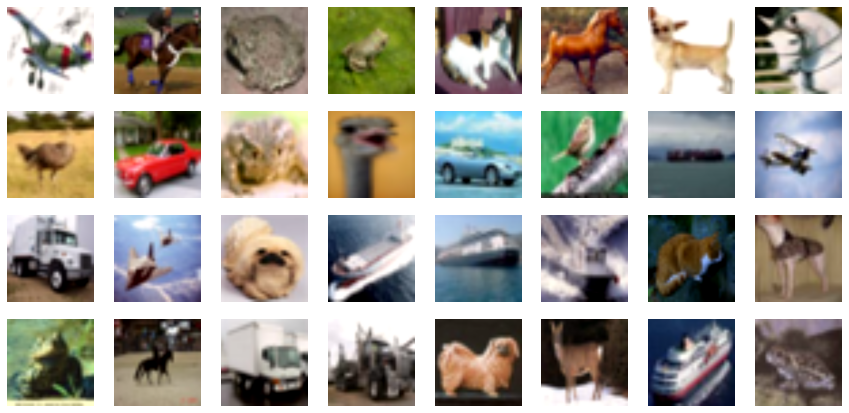

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#可视化数据集
def visual_input_data(dataset):
    data = next(dataset.create_dict_iterator())
    images = data["image"]
    labels = data["label"]
    print("Tensor of image", images.shape)
    print("Labels:", labels)
    plt.figure(figsize=(15, 15))
    for i in range(0,32):
        # get the image and its corresponding label
        data_image = images[i].asnumpy()
        # data_label = labels[i]
        # process images for display
        data_image = np.transpose(data_image, (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        data_image = std * data_image + mean
        data_image = np.clip(data_image, 0, 1)
        # display image
        plt.subplot(8, 8, i+1)
        plt.imshow(data_image)
        # plt.title(class_name[int(labels[i].asnumpy())], fontsize=10)
        plt.axis("off")

    plt.show()

visual_input_data(dataset_train)

### 构建Fire模块

在SqueezeNet中，Fire是实现该网络模型参数量少的关键所在，该模块主要包含了squeeze层和expand层，在squeeze层中只包含了1×1的滤波器，而在expand层中包含了1×1和3×3的滤波器，正是由于1×1滤波器的使用，使得该网络的参数量大幅度的降低，而下面的Fire模块一共有四个参数，第一个参数是通道数，第二个参数是squeeze层的1×1滤波器的数量，第三个参数是expand层中1×1滤波器的数量，最后一个参数是expand层3×3滤波器的数量，ReLU用于squeeze和expand层的激活。

In [4]:
class Fire(nn.Cell):
    """
    Fire network definition.
    """
    def __init__(self, inplanes, squeeze_planes, expand1x1_planes,
                 expand3x3_planes):
        super(Fire, self).__init__()
        self.inplanes = inplanes
        self.squeeze = nn.Conv2d(inplanes,
                                 squeeze_planes,
                                 kernel_size=1,
                                 has_bias=True)
        self.squeeze_activation = nn.ReLU()
        self.expand1x1 = nn.Conv2d(squeeze_planes,
                                   expand1x1_planes,
                                   kernel_size=1,
                                   has_bias=True)
        self.expand1x1_activation = nn.ReLU()
        self.expand3x3 = nn.Conv2d(squeeze_planes,
                                   expand3x3_planes,
                                   kernel_size=3,
                                   pad_mode='same',
                                   has_bias=True)
        self.expand3x3_activation = nn.ReLU()
        self.concat = P.Concat(axis=1)

    def construct(self, x):
        x = self.squeeze_activation(self.squeeze(x))
        return self.concat((self.expand1x1_activation(self.expand1x1(x)),
                            self.expand3x3_activation(self.expand3x3(x))))

### 构建SqueezeNet网络模型

SqueezeNet主要由Fire模块组成，中间也有一些maxpool和conv层，使用该模型时，直接将数据集中的类型数量作为参数输入即可，例如net = SqueezeNet(10)就创建好一个用于10分类的SqueezeNet模型

In [5]:
class SqueezeNet(nn.Cell):
    r"""SqueezeNet model architecture from the `"SqueezeNet: AlexNet-level
    accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.

    Get SqueezeNet neural network.

    Args:
        num_classes (int): Class number.

    Returns:
        Cell, cell instance of SqueezeNet neural network.

    Examples:
        >>> net = SqueezeNet(10)
    """
    def __init__(self, num_classes=10):
        super(SqueezeNet, self).__init__()

        self.features = nn.SequentialCell([
            nn.Conv2d(3,
                      96,
                      kernel_size=7,
                      stride=2,
                      pad_mode='valid',
                      has_bias=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Fire(96, 16, 64, 64),
            Fire(128, 16, 64, 64),
            Fire(128, 32, 128, 128),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Fire(256, 32, 128, 128),
            Fire(256, 48, 192, 192),
            Fire(384, 48, 192, 192),
            Fire(384, 64, 256, 256),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Fire(512, 64, 256, 256),
        ])

        # Final convolution is initialized differently from the rest
        self.final_conv = nn.Conv2d(512,
                                    num_classes,
                                    kernel_size=1,
                                    has_bias=True)
        self.dropout = nn.Dropout(keep_prob=0.5)
        self.relu = nn.ReLU()
        self.mean = P.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.custom_init_weight()

    def custom_init_weight(self):
        """
        Init the weight of Conv2d in the net.
        """
        for _, cell in self.cells_and_names():
            if isinstance(cell, nn.Conv2d):
                if cell is self.final_conv:
                    cell.weight.set_data(
                        weight_init.initializer('normal', cell.weight.shape,
                                                cell.weight.dtype))
                else:
                    cell.weight.set_data(
                        weight_init.initializer('he_uniform',
                                                cell.weight.shape,
                                                cell.weight.dtype))
                if cell.bias is not None:
                    cell.bias.set_data(
                        weight_init.initializer('zeros', cell.bias.shape,
                                                cell.bias.dtype))

    def construct(self, x):
        x = self.features(x)
        x = self.dropout(x)
        x = self.final_conv(x)
        x = self.relu(x)
        x = self.mean(x, (2, 3))
        x = self.flatten(x)

        return x

### 构建SqueezeNet_Residual模型

下面是带有简单旁路的SqueezeNet模型

In [7]:
class SqueezeNet_Residual(nn.Cell):
    r"""SqueezeNet with simple bypass model architecture from the `"SqueezeNet:
    AlexNet-level accuracy with 50x fewer parameters and <0.5MB model size"
    <https://arxiv.org/abs/1602.07360>`_ paper.

    Get SqueezeNet with simple bypass neural network.

    Args:
        num_classes (int): Class number.

    Returns:
        Cell, cell instance of SqueezeNet with simple bypass neural network.

    Examples:
        >>> net = SqueezeNet_Residual(10)
    """
    def __init__(self, num_classes=10):
        super(SqueezeNet_Residual, self).__init__()

        self.conv1 = nn.Conv2d(3,
                               96,
                               kernel_size=7,
                               stride=2,
                               pad_mode='valid',
                               has_bias=True)
        self.fire2 = Fire(96, 16, 64, 64)
        self.fire3 = Fire(128, 16, 64, 64)
        self.fire4 = Fire(128, 32, 128, 128)
        self.fire5 = Fire(256, 32, 128, 128)
        self.fire6 = Fire(256, 48, 192, 192)
        self.fire7 = Fire(384, 48, 192, 192)
        self.fire8 = Fire(384, 64, 256, 256)
        self.fire9 = Fire(512, 64, 256, 256)
        # Final convolution is initialized differently from the rest
        self.conv10 = nn.Conv2d(512, num_classes, kernel_size=1, has_bias=True)

        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=3, stride=2)
        self.add = P.Add()
        self.dropout = nn.Dropout(keep_prob=0.5)
        self.mean = P.ReduceMean(keep_dims=True)
        self.flatten = nn.Flatten()
        self.custom_init_weight()

    def custom_init_weight(self):
        """
        Init the weight of Conv2d in the net.
        """
        for _, cell in self.cells_and_names():
            if isinstance(cell, nn.Conv2d):
                if cell is self.conv10:
                    cell.weight.set_data(
                        weight_init.initializer('normal', cell.weight.shape,
                                                cell.weight.dtype))
                else:
                    cell.weight.set_data(
                        weight_init.initializer('xavier_uniform',
                                                cell.weight.shape,
                                                cell.weight.dtype))
                if cell.bias is not None:
                    cell.bias.set_data(
                        weight_init.initializer('zeros', cell.bias.shape,
                                                cell.bias.dtype))

    def construct(self, x):
        """
        Construct squeezenet_residual.
        """
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.fire2(x)
        x = self.add(x, self.fire3(x))
        x = self.fire4(x)
        x = self.max_pool2d(x)
        x = self.add(x, self.fire5(x))
        x = self.fire6(x)
        x = self.add(x, self.fire7(x))
        x = self.fire8(x)
        x = self.max_pool2d(x)
        x = self.add(x, self.fire9(x))
        x = self.dropout(x)
        x = self.conv10(x)
        x = self.relu(x)
        x = self.mean(x, (2, 3))
        x = self.flatten(x)

        return x

### 测试模型输出的数据形状

In [6]:
net =  SqueezeNet(num_classes=10)
uniform = ms.ops.UniformReal()
input = uniform((32, 3, 224, 224)) 
output = net(input)

print(output.shape)

[WARNING] DEVICE(9249,ffffa747a780,python):2022-11-04-19:17:03.082.401 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/UniformReal-op32] don't support int64, reduce precision from int64 to int32.


(32, 10)


### 定义损失率

Squeezenet模型在训练过程中学习率lr随着训练步骤的增加逐渐减小，从而使得模型最后的分类准确度得到上升，下面定义了学习率的生成函数，主要定义了四种学习率的下降过程，分为线性和非线性，在调用函数时直接在lr_decay_mode输入不同的模式就可以得到不同的学习率数组， 四种模式分别是steps, poly, linear 和 cosine，我们以linear为例说明，在这个过程中学习率随着训练的进行，线性下降从lr_max下降到lr_end,实现了训练前期学习速度快，后期缓慢收敛，防止梯度在在最小值附件来回震荡

In [7]:
import math
import numpy as np


def get_lr(lr_init, lr_end, lr_max, total_epochs, warmup_epochs,
           pretrain_epochs, steps_per_epoch, lr_decay_mode):
    """
    generate learning rate array

    Args:
        lr_init(float): init learning rate
        lr_end(float): end learning rate
        lr_max(float): max learning rate
        total_epochs(int): total epoch of training
        warmup_epochs(int): number of warmup epochs
        pretrain_epochs(int): number of pretrain epochs
        steps_per_epoch(int): steps of one epoch
        lr_decay_mode(string): learning rate decay mode,
                               including steps, poly, linear or cosine
    Returns:
        np.array, learning rate array
    """

    lr_each_step = []
    total_steps = steps_per_epoch * total_epochs
    warmup_steps = steps_per_epoch * warmup_epochs
    pretrain_steps = steps_per_epoch * pretrain_epochs
    decay_steps = total_steps - warmup_steps

    if lr_decay_mode == 'steps':
        decay_epoch_index = [
            0.3 * total_steps, 0.6 * total_steps, 0.8 * total_steps
        ]
        for i in range(total_steps):
            if i < decay_epoch_index[0]:
                lr = lr_max
            elif i < decay_epoch_index[1]:
                lr = lr_max * 0.1
            elif i < decay_epoch_index[2]:
                lr = lr_max * 0.01
            else:
                lr = lr_max * 0.001
            lr_each_step.append(lr)

    elif lr_decay_mode == 'poly':
        for i in range(total_steps):
            if i < warmup_steps:
                lr = linear_warmup_lr(i, warmup_steps, lr_max, lr_init)
            else:
                base = (1.0 - (i - warmup_steps) / decay_steps)
                lr = lr_max * base * base
            lr_each_step.append(lr)

    elif lr_decay_mode == 'linear':
        for i in range(total_steps):
            if i < warmup_steps:
                lr = linear_warmup_lr(i, warmup_steps, lr_max, lr_init)
            else:
                lr = lr_max - (lr_max - lr_end) * (i -
                                                   warmup_steps) / decay_steps
            lr_each_step.append(lr)

    elif lr_decay_mode == 'cosine':
        for i in range(total_steps):
            if i < warmup_steps:
                lr = linear_warmup_lr(i, warmup_steps, lr_max, lr_init)
            else:
                linear_decay = (total_steps - i) / decay_steps
                cosine_decay = 0.5 * (
                    1 + math.cos(math.pi * 2 * 0.47 *
                                 (i - warmup_steps) / decay_steps))
                decayed = linear_decay * cosine_decay + 0.00001
                lr = lr_max * decayed
            lr_each_step.append(lr)

    else:
        raise NotImplementedError(
            'Learning rate decay mode [{:s}] cannot be recognized'.format(
                lr_decay_mode))

    lr_each_step = np.array(lr_each_step).astype(np.float32)
    learning_rate = lr_each_step[pretrain_steps:]

    return learning_rate


def linear_warmup_lr(current_step, warmup_steps, base_lr, init_lr):
    lr_inc = (base_lr - init_lr) / warmup_steps
    lr = init_lr + lr_inc * current_step
    return lr

lr = get_lr(lr_init=0,
                lr_end=0,
                lr_max=0.01,
                total_epochs=30,
                warmup_epochs=5,
                pretrain_epochs=0,
                steps_per_epoch=1562,
                lr_decay_mode="linear")
lr =Tensor(lr)

# print(type(lr[2]))




### 训练SqueezeNet模型
设置epoch参数为30，训练集划分batch是每批32张图片，一共会有1562批次，可以看见在训练过程中损失率呈现下降趋势。

In [9]:
from mindspore.nn.optim.momentum import Momentum
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.nn.loss import SoftmaxCrossEntropyWithLogits
from mindspore.train.model import Model


#保存模型
config_ck = ms.CheckpointConfig(save_checkpoint_steps=1562, keep_checkpoint_max=10)

ckpoint = ms.ModelCheckpoint(prefix="SqueezeNet", directory="./SqueezeNet2", config=config_ck)

# loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True)
loss = SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
#优化器
# opt = nn.Momentum(net.trainable_params(), learning_rate=0.001, momentum=0.8)
opt = Momentum(filter(lambda x: x.requires_grad, net.get_parameters()),
                       lr,
                       0.9,
                     weight_decay=1e-4)
model = Model(net, loss_fn=loss, optimizer=opt, metrics={'accuracy'})
time_cb = TimeMonitor(data_size=step_size)
loss_cb = LossMonitor()
#训练模型
model.train(30, dataset_train, callbacks=[ckpoint, time_cb,loss_cb])


[WARNING] DEVICE(9249,ffffa747a780,python):2022-11-04-19:28:05.610.861 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/dropout-Dropout/DropoutGenMask-op1154] don't support int64, reduce precision from int64 to int32.


epoch: 1 step: 1562, loss is 1.6105313301086426
Train epoch time: 111595.874 ms, per step time: 71.444 ms
epoch: 2 step: 1562, loss is 1.8702455759048462
Train epoch time: 109914.535 ms, per step time: 70.368 ms
epoch: 3 step: 1562, loss is 1.611440896987915
Train epoch time: 104074.053 ms, per step time: 66.629 ms
epoch: 4 step: 1562, loss is 1.3654391765594482
Train epoch time: 104066.905 ms, per step time: 66.624 ms
epoch: 5 step: 1562, loss is 1.4371674060821533
Train epoch time: 103017.924 ms, per step time: 65.953 ms
epoch: 6 step: 1562, loss is 1.139390468597412
Train epoch time: 102618.056 ms, per step time: 65.697 ms
epoch: 7 step: 1562, loss is 0.5817681550979614
Train epoch time: 99074.983 ms, per step time: 63.428 ms
epoch: 8 step: 1562, loss is 1.2672991752624512
Train epoch time: 109073.883 ms, per step time: 69.830 ms
epoch: 9 step: 1562, loss is 0.9498278498649597
Train epoch time: 101542.789 ms, per step time: 65.008 ms
epoch: 10 step: 1562, loss is 1.023105263710022
T

### 模型评估

在之前划分的测试集上面进行模型的评估，得到在测试集上的准确度

In [10]:
acc = model.eval(dataset_eval)

print("{}".format(acc))

{'accuracy': 0.8145032051282052}


### 保存模型
调用mindspore的save_checkpoint可以保存训练好的SqueezeNet模型，下面保存模型在根目录，并取名为
squeezenet.ckpt

In [18]:
# Save checkpoint
import mindspore
mindspore.save_checkpoint(net, "squeezenet.ckpt")
print("Saved Model to squeezenet")

Saved Model to squeezenet


### 可视化模型

调用之前训练好的模型进行预测，并且将预测结果可视化出来，红色的图片代表是预测错误的图片，蓝色的图片代表是预测正确的图片。图片的标题为SqueezeNet预测的图片所属类型的结果。

[8 8 9 6 1 8 2 9 4 7 3 4 3 5 2 6 2 4 5 7 0 9 5 1 6 7 3 1 3 9 9 8]
[8 8 8 6 1 8 2 9 4 7 3 4 3 3 2 6 2 4 5 7 0 9 5 1 4 7 3 1 4 9 9 8]


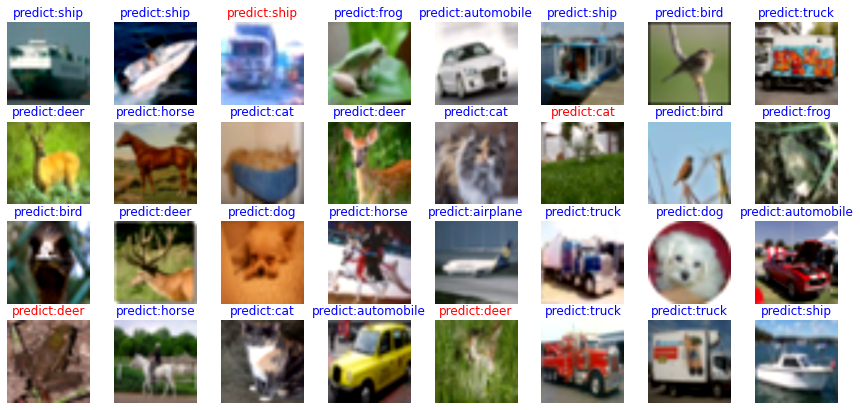

In [21]:
from mindspore.train import Model
from mindspore import load_checkpoint, load_param_into_net

# define visualize_model()，visualize model prediction
def visualize_model(best_ckpt_path, val_ds):
    network = SqueezeNet(10)
    # load model parameters
    param_dict = load_checkpoint(best_ckpt_path)
    load_param_into_net(network, param_dict)
    model = Model(network)
    # load the data of the validation set for validation
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    print(labels)
    class_name = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}
    # prediction image category
    output = model.predict(Tensor(data['image']))
    # print(output.shape)
    pred = np.argmax(output.asnumpy(), axis=1)
    # print(pred.shape)
    print(pred)

    # display the image and the predicted value of the image
    plt.figure(figsize=(15, 7))
    for i in range(0,32):
        plt.subplot(4, 8, i + 1)
        # if the prediction is correct, it is displayed in blue; if the prediction is wrong, it is displayed in red
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(class_name[pred[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()


# the best ckpt file obtained by model tuning is used to predict the images of the validation set
# (need to go to cpu_default_config.yaml set ckpt_path as the best ckpt file path）
# visualize_model("./SqueezeNet/SqueezeNet_4-2_1562.ckpt", dataset_eval)
visualize_model("./squeezenet.ckpt", dataset_eval)

## 总结
本案例使用MindSpore框架实现了SqueezeNet训练CIFAR10数据集并且评估模型的完整过程，包括数据集的下载和处理，模型的搭建，模型的训练，以及模型的测试评估和保存，最后我们可视化了模型的预测效果，通过次案例我们可以对SqueezeNet的原理有更加深刻的了解，并且更加熟悉MindSpore框架的基本使用方法。


## Reference
[1] Iandola F N, Han S, Moskewicz M W, et al. Squeezenet: Alexnet-level accuracy with 50x fewer parameters and< 0.5 mb model size[J]. arXiv preprint arXiv:1602.07360, 2016.
